In [28]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import numpy as np
import matplotlib.pylab as plt
import math
import tqdm
import time
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
import zipfile

%matplotlib inline

# Загружаем датасет

In [14]:
%%bash
kaggle competitions download -c 2019s-neuralnet-track
unzip hw_1_train.pickle.zip          -d data/
unzip hw_1_test_no_lables.pickle.zip -d data/

01_Homework_Template.ipynb: Skipping, found more recently modified local copy (use --force to force download)
sample_solution_random.csv: Skipping, found more recently modified local copy (use --force to force download)


Archive:  hw_1_train.pickle.zip
  inflating: data/hw_1_train.pickle  
Archive:  hw_1_test_no_lables.pickle.zip
  inflating: data/hw_1_test_no_lables.pickle  


100%|██████████| 531k/531k [00:00<00:00, 3.06MB/s]
100%|██████████| 1.63M/1.63M [00:00<00:00, 3.98MB/s]


In [3]:
with open('data/hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('data/hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

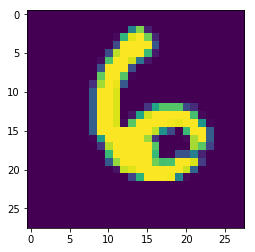

In [4]:
# Пример, как можно визуализировать данные
plt.imshow(train['data'][5].reshape(28,28))
plt.show()

# Обучаем модель

Реализуем класс логистической регрессии, который:
* Нормирует входные данные (данную задачу не доверим пользователю)
* Значение предсказаний равны 0 или 1 (Единица для первого класса)
* Если задан параметр debug, то разделяет исходные данные на train и test. И функция fit возвращает сходимость функции потерь и точности, а именно четыре списка train_loss, train_acc, test_loss, train_acc

In [63]:
A = np.arange(5)
b = np.arange(5).reshape(1, -1)
np.dot(A, b.T)

array([30])

In [225]:
class LogisticRegression():
    def __init__(self, iter_num=10000, handle_step=100, grad_step=0.001, seed=113, tolerance=1e-15, eps=1e-5):
        self._seed = seed
        self._iter_num = iter_num
        self._tolerance = tolerance
        self._eps = eps
        self._handle_step = handle_step
        self._grad_step=grad_step
        self._loss = [[], []]
        self._acc = [[], []]
        self._scalar = None
        self._X = None
        self._y = None
        self._X_test = None
        self._y_test = None
        
    def logistic_grad(self, w, i):
        """The gradient of the logistic loss function
        
        Keyword arguments:
        
        w --- point of coefficients
        i --- magnitude of gradient on j-sample element
        """
        assert(self._y.shape == (self._X.shape[0], 1))
        assert(w.shape == (1, self._X.shape[1]))
        
        grad = 0
        y = 2 * self._y - 1
        grad = - y[i] * self._X[i] / \
                    ( 1 + np.exp( y[i] * np.dot(self._X[i], w.T)))

        return grad
    
    def stochastic_gradint(self):
        w = self._w
        for i in range(self._iter_num):
            j = np.random.randint(0, self._X.shape[0])

            alpha = self._grad_step #/ np.sqrt(np.sqrt(i  + 1))
            grad_step = alpha * self.logistic_grad(w, j)
            if np.linalg.norm(grad_step) < self._tolerance:
                break
                
            w = w - grad_step
                
            if i % self._handle_step == 0:
                self.handle_coef(w)
                
        self.handle_coef(w)
                
    def set_coef(self):
        np.random.seed(self._seed)
        # TODO SMART FEATURES
        self._w = np.random.normal(scale=0.001, size = (1, self._X.shape[1]))
    
    def normolize(self, X):
        assert(self._scalar is not None)
        return self._scalar.transform(X)
        
    def loss_function(self, y_count, y_real):
        y_count = np.clip(y_count, self._eps, 1 - self._eps)
        return -np.mean(y_real * np.log(y_count) + (1-y_real) * np.log(1-y_count))
    
    def acc_function(self, y_count, y_real):
        return np.mean(y_count==y_real)
    
    def handle_coef(self, w):
        assert(self._loss is not None)
        assert(self._acc is not None)
        self._w = w
        
        X_list = [self._X, self._X_test]
        y_list = [self._y, self._y_test]
        
        for i in range(2):
            proba = self.predict_proba(X_list[i], is_normolized=True)
            classes = proba > .5
            y = y_list[i]
            self._loss[i].append(self.loss_function(proba, y))
            self._acc[i].append(self.acc_function(classes, y))
        
    def fit(self, X, y):
        self._X, self._X_test, \
            self._y, self._y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.2,
                                                                    random_state=42)
        self._scalar = StandardScaler().fit(self._X)
        self._X = self.normolize(self._X)
        self._X_test = self.normolize(self._X_test)
        
        self._y_test = self._y_test.reshape((-1, 1))
        self._y = self._y.reshape((-1, 1))
        self.set_coef()
        self.stochastic_gradint()
        
        return self._loss[0], self._acc[0], self._loss[1], self._acc[1]
        
    def predict_proba(self, X, is_normolized=False):
        if not is_normolized:
            X = self.normolize(X)
        p = (1. / (1. + np.exp(-np.dot(X, self._w.T))))
        return p
    
    def predict(self, X, threshold=0.5, is_normolized=False):
        p = self.predict_proba(X, is_normolized)
        
        return p >= threshold

In [226]:
X = train['data']
y = np.where(train['labels'] == 6, 1, 0)
args = {'iter_num' : 150000,  'handle_step' : 100, 'grad_step' : 0.0001}

In [227]:
sr = LogisticRegression(**args)

train_loss, train_acc, test_loss, test_acc = sr.fit(X, y)
print("LOSS:\t%f" % test_loss[-1],
      "\nACC:\t%f" % test_acc[-1])

/home/alex-kozinov/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


LOSS:	0.043445 
ACC:	0.985500


# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

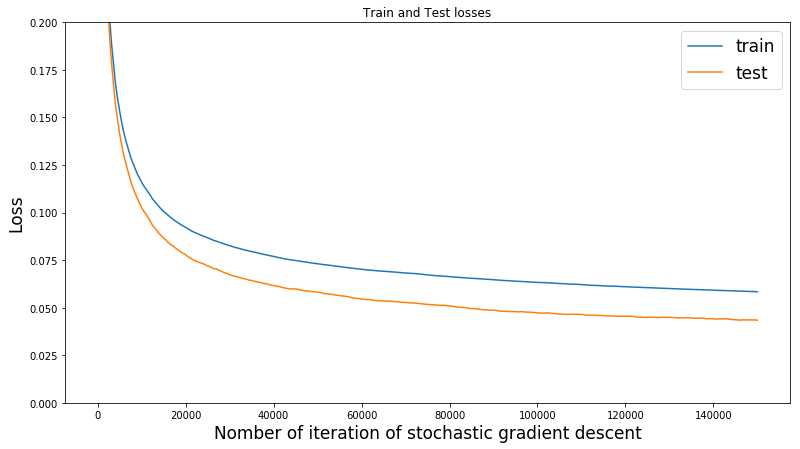

In [228]:
grid = np.arange(0, args['iter_num'] + args['handle_step'], args['handle_step'])


plt.figure(figsize=(13, 7))
plt.title('Train and Test losses')
plt.xlabel('Nomber of iteration of stochastic gradient descent', fontsize=17)
plt.ylabel('Loss', fontsize=17)
plt.ylim(0, 0.2)

plt.plot(grid, train_loss, label='train')
plt.plot(grid, test_loss, label='test')
plt.legend(fontsize=17)
plt.show()

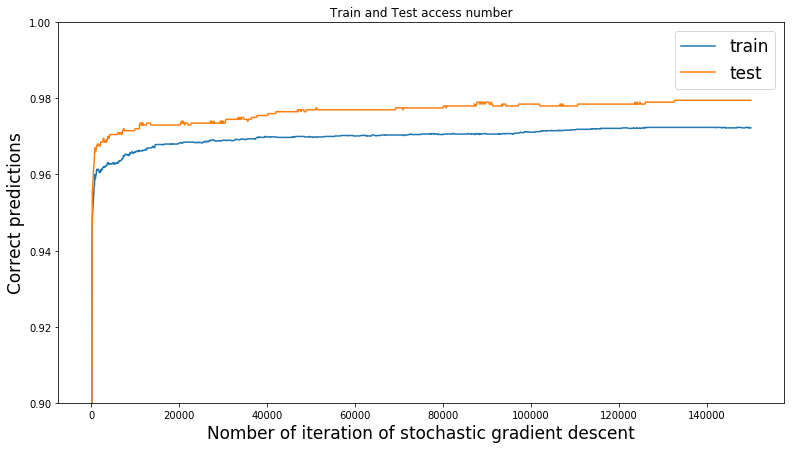

In [224]:
plt.figure(figsize=(13, 7))
plt.title('Train and Test access number')
plt.xlabel('Nomber of iteration of stochastic gradient descent', fontsize=17)
plt.ylabel('Сorrect predictions', fontsize=17)
plt.ylim(0.90, 1)

plt.plot(grid, train_acc, label='train')
plt.plot(grid, test_acc, label='test')
plt.legend(fontsize=17)
plt.show()

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [209]:
X = test_no_lables['data']

Y_pred = sr.predict_proba(X)
Y_pred.shape

/home/alex-kozinov/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(3189, 1)

In [210]:
X = test_no_lables['data']

Y_pred = sr.predict_proba(X)

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(len(test_no_lables['data'])):
        print(i, Y_pred[i][0], sep=',', file=fout)

/home/alex-kozinov/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/34e77301ef914c5792e4f4306144a6b3 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МФТИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем <ваша фамилия>.ipynb